In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from collections import defaultdict # For easier subject counts
import operator
from tqdm.notebook import tqdm
import datetime
import re
import pickle
import seaborn as sns
import random
# Optional: for better display in Jupyter
from IPython.display import display
from scipy.stats import truncnorm

In [170]:
def load_and_prepare_disease_analysis(filepath, diseases):
    """
    Loads simulation results and prepares a dictionary of time series for infected and recovered counts
    for each disease, as well as percent infected/recovered by subject and college.
    Returns:
        - df: The loaded DataFrame
        - disease_labels: List of disease names
        - transmission_rates: Dict of transmission rates
        - recovery_rates: Dict of recovery rates
        - hours: List of time steps
        - results: Dict[label]['infected'/'recovered'] = list of counts over time
        - subject_infection_pct: Dict[label][subject][hour] = % infected
        - college_infection_pct: Dict[label][college][hour] = % infected
    """
    import re
    import pandas as pd

    print(f"Loading simulation results from '{filepath}'...")
    try:
        df = pd.read_csv(filepath)
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return None

    # Identify disease columns and time steps
    disease_cols = sorted(
        [col for col in df.columns if col.startswith('Disease_T_')],
        key=lambda x: int(re.search(r'(\d+)', x).group(1))
    )
    if not disease_cols:
        print("Error: No 'Disease_T_...' columns found in the provided file.")
        return None

    disease_labels = [d.name for d in diseases]
    transmission_rates = {d.name: d.transmission_rate for d in diseases}
    recovery_rates = {d.name: d.recovery_rate for d in diseases}
    hours = [int(re.search(r'(\d+)', col).group(1)) for col in disease_cols]

    # Preallocate results
    results = {label: {'infected': np.zeros(len(hours), dtype=int), 'recovered': np.zeros(len(hours), dtype=int)} for label in disease_labels}

    # Prepare percent infected by subject and college
    subjects = df['Subject'].unique() if 'Subject' in df.columns else []
    colleges = df['College'].unique() if 'College' in df.columns else []
    subject_infection_pct = {disease: pd.DataFrame(index=subjects, columns=hours, dtype=float) for disease in disease_labels}
    college_infection_pct = {disease: pd.DataFrame(index=colleges, columns=hours, dtype=float) for disease in disease_labels}

    # Vectorized processing for each time step
    for idx, col in enumerate(disease_cols):
        disease_states = df[col].astype(str).str.zfill(len(disease_labels))
        for i, label in enumerate(disease_labels):
            # Use numpy for fast counting
            states = disease_states.str[i]
            infected = (states == '1').sum()
            recovered = (states == '2').sum()
            results[label]['infected'][idx] = infected
            results[label]['recovered'][idx] = recovered

            # Only compute groupby if needed
            if len(subjects) > 0 or len(colleges) > 0:
                df['_infected_tmp'] = (states == '1')
                if len(subjects) > 0:
                    pct_infected = df.groupby('Subject')['_infected_tmp'].mean() * 100
                    subject_infection_pct[label][hours[idx]] = pct_infected
                if len(colleges) > 0:
                    pct_infected = df.groupby('College')['_infected_tmp'].mean() * 100
                    college_infection_pct[label][hours[idx]] = pct_infected
    if '_infected_tmp' in df.columns:
        df.drop(columns=['_infected_tmp'], inplace=True)

    # Convert results arrays to lists for compatibility
    for label in disease_labels:
        results[label]['infected'] = results[label]['infected'].tolist()
        results[label]['recovered'] = results[label]['recovered'].tolist()

    return {
        'df': df,
        'disease_labels': disease_labels,
        'transmission_rates': transmission_rates,
        'recovery_rates': recovery_rates,
        'hours': hours,
        'results': results,
        'subject_infection_pct': subject_infection_pct,
        'college_infection_pct': college_infection_pct
    }

In [171]:
class Disease:
    def __init__(self, name, transmission_rate, recovery_rate):
        self.name = name  # e.g. 'A'
        self.transmission_rate = transmission_rate  # probability of infection per contact per hour
        self.recovery_rate = recovery_rate  # probability of recovery per hour

diseases = [
    Disease('A', transmission_rate=0.1, recovery_rate=0.01), #Students ill for on average, 5 days. 
    Disease('B', transmission_rate=0.05, recovery_rate=0.01),
    Disease('C', transmission_rate=0.01, recovery_rate=0.01),
    Disease('D', transmission_rate=0.005, recovery_rate=0.01),
    Disease('E', transmission_rate=0.1, recovery_rate=0.025), #Students ill for on average, 2 days. 
    Disease('F', transmission_rate=0.05, recovery_rate=0.025),
    Disease('G', transmission_rate=0.02, recovery_rate=0.025),
]

In [172]:
analysis_data = load_and_prepare_disease_analysis('Disease_track_completeV3.csv', diseases)

# Unpack for convenience
df = analysis_data['df']
disease_labels = analysis_data['disease_labels']
transmission_rates = analysis_data['transmission_rates']
recovery_rates = analysis_data['recovery_rates']
hours = analysis_data['hours']
results = analysis_data['results']
subject_infection_pct = analysis_data['subject_infection_pct']
college_infection_pct = analysis_data['college_infection_pct']

# Load infection event log (for superspreader/location/timing analysis)
infection_log = pd.read_csv('infection_events_log.csv')

Loading simulation results from 'Disease_track_completeV3.csv'...
File loaded successfully.


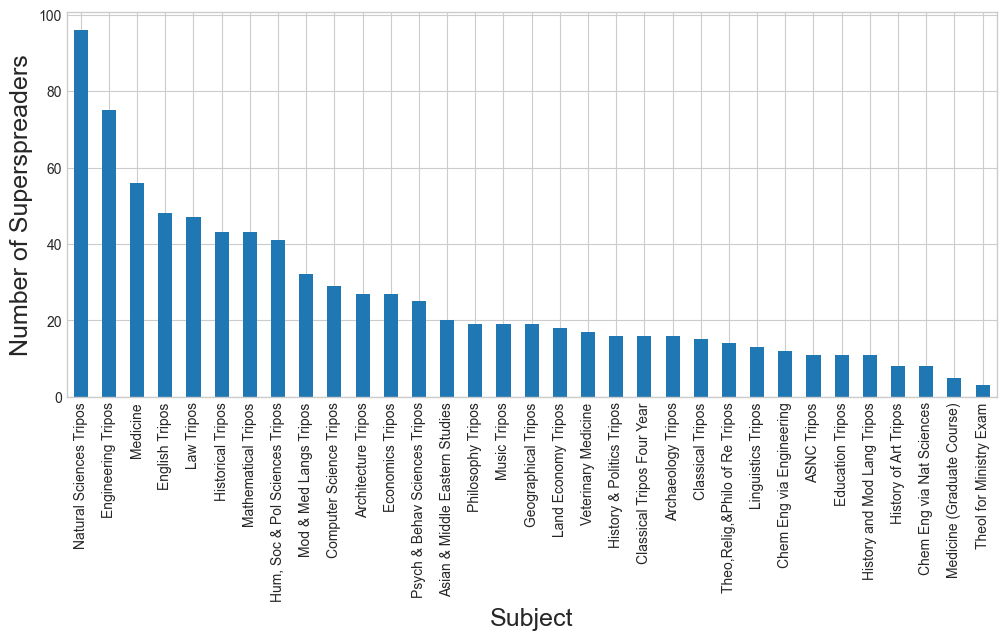

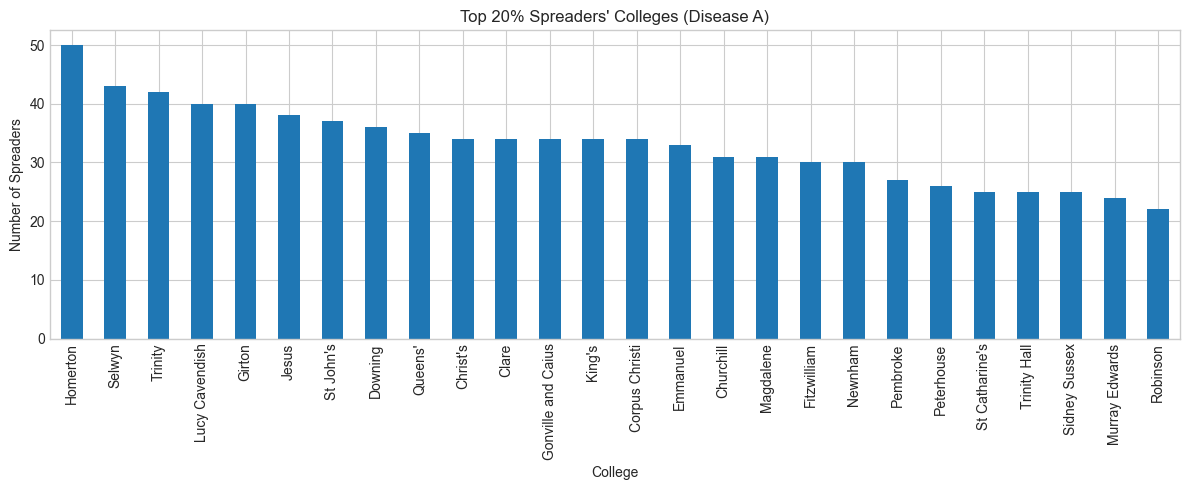

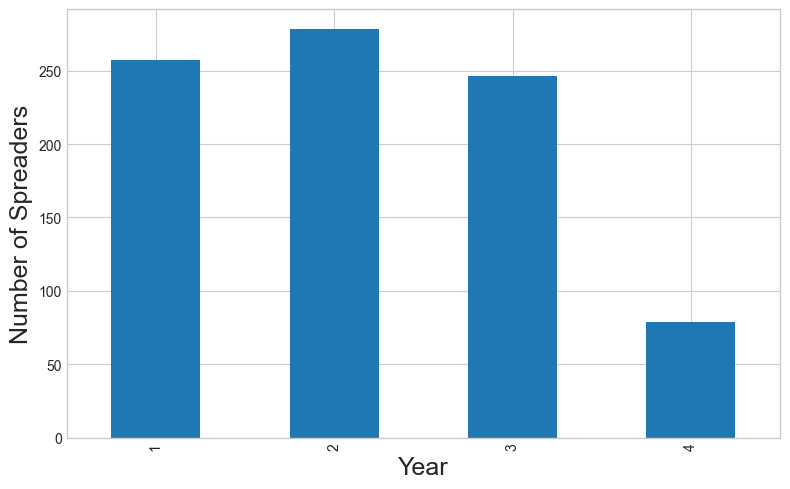

In [173]:
# --- Superspreader Analysis: Colleges, Subjects, Year Groups ---

# Choose disease letter (e.g., 'A')
disease_letter = 'A'

# 1. Identify top 20% spreaders for the chosen disease
spread_counts = infection_log[infection_log['disease'] == disease_letter]['source_student'].value_counts()
top_n = int(np.ceil(0.2 * len(spread_counts)))
top_spreaders = spread_counts.head(top_n).index

# 2. Get their info from df (ensure StudentID is present)
if 'StudentID' not in df.columns:
    print("StudentID column not found in df.")
else:
    top_spreader_info = df[df['StudentID'].isin(top_spreaders)]

    # 3. Plot subject distribution
    plt.figure(figsize=(12, 5))
    top_spreader_info['Subject'].value_counts().plot(kind='bar')
    #plt.title(f"Top 20% Spreaders' Subjects (Disease {disease_letter})")
    plt.xlabel('Subject', fontsize = 18)
    plt.ylabel('Number of Superspreaders', fontsize=18)
    #plt.tight_layout()
    plt.show()

    # 4. Plot college distribution
    plt.figure(figsize=(12, 5))
    top_spreader_info['College'].value_counts().plot(kind='bar')
    plt.title(f"Top 20% Spreaders' Colleges (Disease {disease_letter})")
    plt.xlabel('College')
    plt.ylabel('Number of Spreaders')
    plt.tight_layout()
    plt.show()

    # 5. Plot year group distribution
    plt.figure(figsize=(8, 5))
    top_spreader_info['Year'].value_counts().sort_index().plot(kind='bar')
    #plt.title(f"Top 20% Spreaders' Year Groups (Disease {disease_letter})")
    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('Number of Spreaders', fontsize=18)
    plt.tight_layout()
    plt.show()

In [174]:
# List out the worst superspreaders and their details, plus their worst 24-hour infection window and locations

disease_letter = 'A'  # Change as needed

# 1. Identify top 20% spreaders for the chosen disease
spread_counts = infection_log[infection_log['disease'] == disease_letter]['source_student'].value_counts()
top_n = int(np.ceil(0.01 * len(spread_counts)))
top_spreaders = spread_counts.head(top_n).index

# 2. Get their info from df (ensure StudentID is present)
if 'StudentID' not in df.columns:
    print("StudentID column not found in df.")
else:
    top_spreader_info = df[df['StudentID'].isin(top_spreaders)][['StudentID', 'Subject', 'Year', 'College']].drop_duplicates()

    # 3. For each superspreader, find their worst 24-hour window and associated locations
    print("Superspreader details and their worst 24-hour infection window:")
    for sid in top_spreader_info['StudentID']:
        events = infection_log[(infection_log['disease'] == disease_letter) & (infection_log['source_student'] == sid)]
        if events.empty:
            continue
        # Sort by time
        times = events['time'].sort_values().values
        # Sliding window to find max infections in any 24-hour period
        max_count = 0
        best_start = None
        best_end = None
        best_locs = []
        for i in range(len(times)):
            start_time = times[i]
            end_time = start_time + 48
            mask = (events['time'] >= start_time) & (events['time'] < end_time)
            count = mask.sum()
            if count > max_count:
                max_count = count
                best_start = start_time
                best_end = end_time
                best_locs = events[mask]['location'].tolist()
        # Print details
        info = top_spreader_info[top_spreader_info['StudentID'] == sid].iloc[0]
        print(f"StudentID: {info['StudentID']}, Subject: {info['Subject']}, Year: {info['Year']}, College: {info['College']}")
        print(f"  Max infections in any 24-hour window: {max_count}")
        print(f"  Window: T={best_start} to T={best_end-1}")
        print(f"  Locations: {best_locs}")
        print("-" * 60)

Superspreader details and their worst 24-hour infection window:
StudentID: 186, Subject: Law Tripos, Year: 1, College: Christ's
  Max infections in any 24-hour window: 4
  Window: T=41 to T=88
  Locations: ["Christ's Library", "Christ's Library", "Christ's Library", "Christ's College Canteen"]
------------------------------------------------------------
StudentID: 432, Subject: Chem Eng via Engineering, Year: 1, College: Churchill
  Max infections in any 24-hour window: 5
  Window: T=71 to T=118
  Locations: ['Churchill College bar', 'Churchill College bar', 'Chem Eng via Engineering Library', 'Churchill College bar', 'Churchill College bar']
------------------------------------------------------------
StudentID: 630, Subject: History and Mod Lang Tripos, Year: 4, College: Churchill
  Max infections in any 24-hour window: 4
  Window: T=92 to T=139
  Locations: ['The Baron of Beef', 'Churchill Library', 'Churchill Library', 'Churchill Library']
------------------------------------------

In [175]:
colleges = list(df['College'].unique())
subjects = list(df['Subject'].unique())

In [176]:
# Select 5 random colleges
random_colleges = np.random.choice(colleges, size=5, replace=False)

# Pick a disease letter, e.g., 'A'


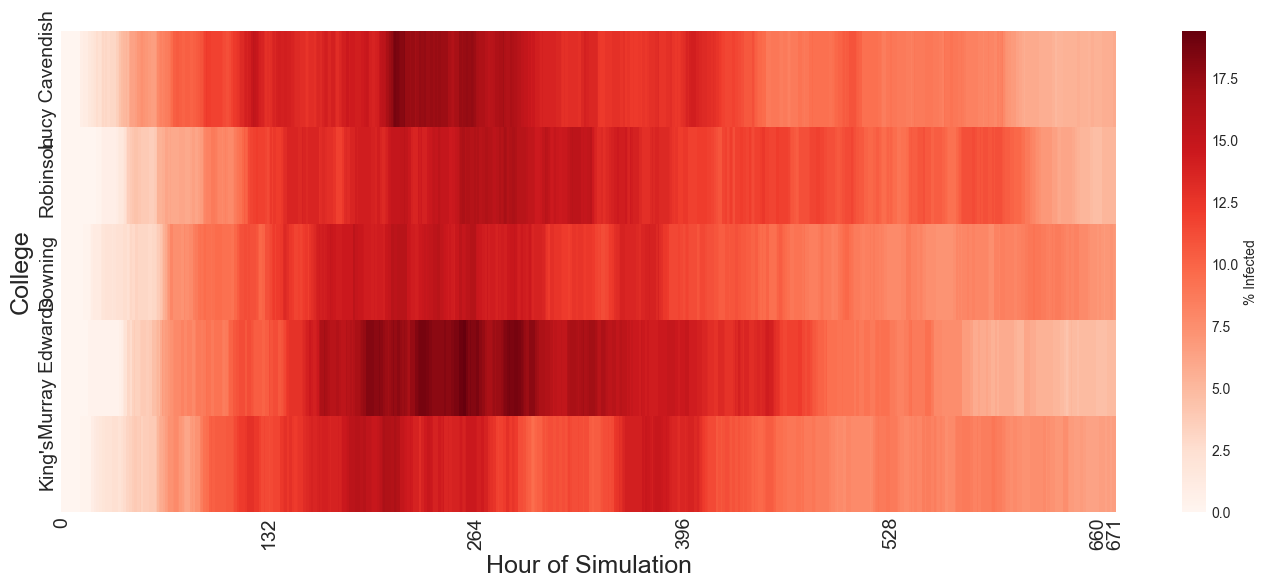

In [177]:
disease = 'A'

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    college_infection_pct[disease].loc[random_colleges].astype(float),
    cmap='Reds',
    cbar_kws={'label': '% Infected'},
    yticklabels=random_colleges
)
plt.xlabel('Hour of Simulation', fontsize=18)
plt.ylabel('College', fontsize=18)

# Reduce number of xticks (e.g., show every 24th hour) and increase font size
xticks = ax.get_xticks()
xtick_labels = [int(label.get_text()) for label in ax.get_xticklabels()]
# Only keep every 24th tick and label, but always keep the first and last
step = 12
if len(xtick_labels) > 1:
    keep = list(range(0, len(xtick_labels), step))
    if (len(xtick_labels)-1) not in keep:
        keep.append(len(xtick_labels)-1)
    ax.set_xticks([xticks[i] for i in keep])
    ax.set_xticklabels([xtick_labels[i] for i in keep], fontsize=14)
else:
    ax.set_xticklabels(xtick_labels, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.show()

In [178]:
random_subjects = np.random.choice(subjects, size=5, replace=False)

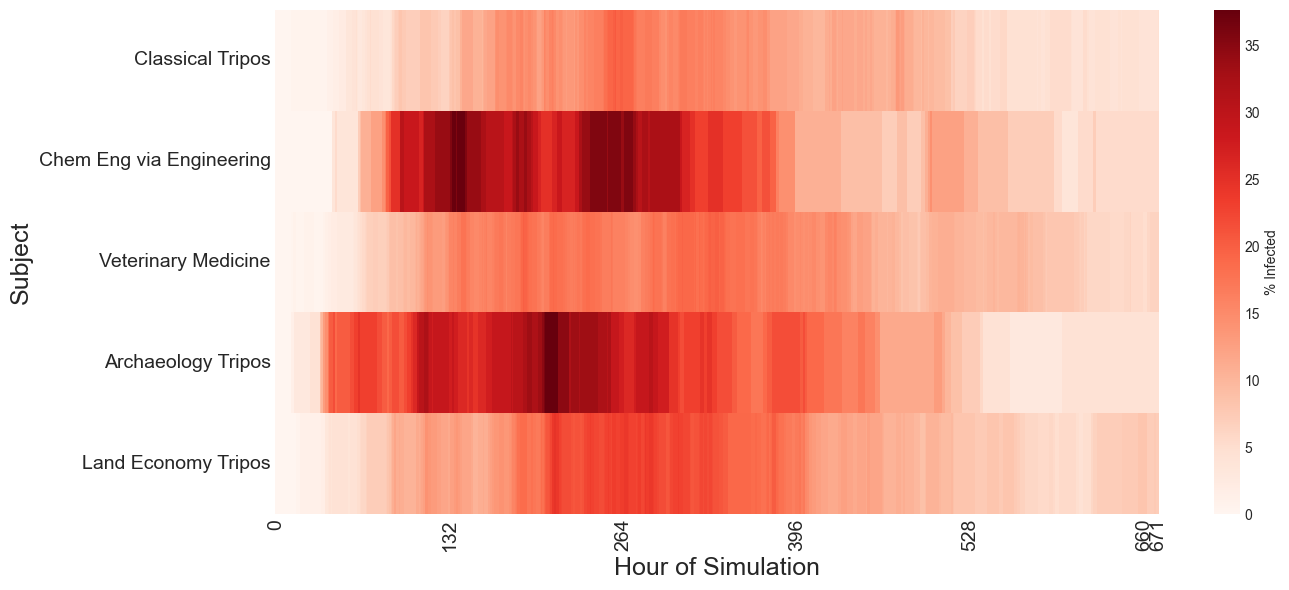

In [179]:
disease = 'A'

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    subject_infection_pct[disease].loc[random_subjects].astype(float),
    cmap='Reds',
    cbar_kws={'label': '% Infected'},
    yticklabels=random_subjects
)
plt.xlabel('Hour of Simulation', fontsize=18)
plt.ylabel('Subject', fontsize=18)

# Reduce number of xticks (e.g., show every 24th hour) and increase font size
xticks = ax.get_xticks()
xtick_labels = [int(label.get_text()) for label in ax.get_xticklabels()]
# Only keep every 24th tick and label, but always keep the first and last
step = 12
if len(xtick_labels) > 1:
    keep = list(range(0, len(xtick_labels), step))
    if (len(xtick_labels)-1) not in keep:
        keep.append(len(xtick_labels)-1)
    ax.set_xticks([xticks[i] for i in keep])
    ax.set_xticklabels([xtick_labels[i] for i in keep], fontsize=14)
else:
    ax.set_xticklabels(xtick_labels, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.show()

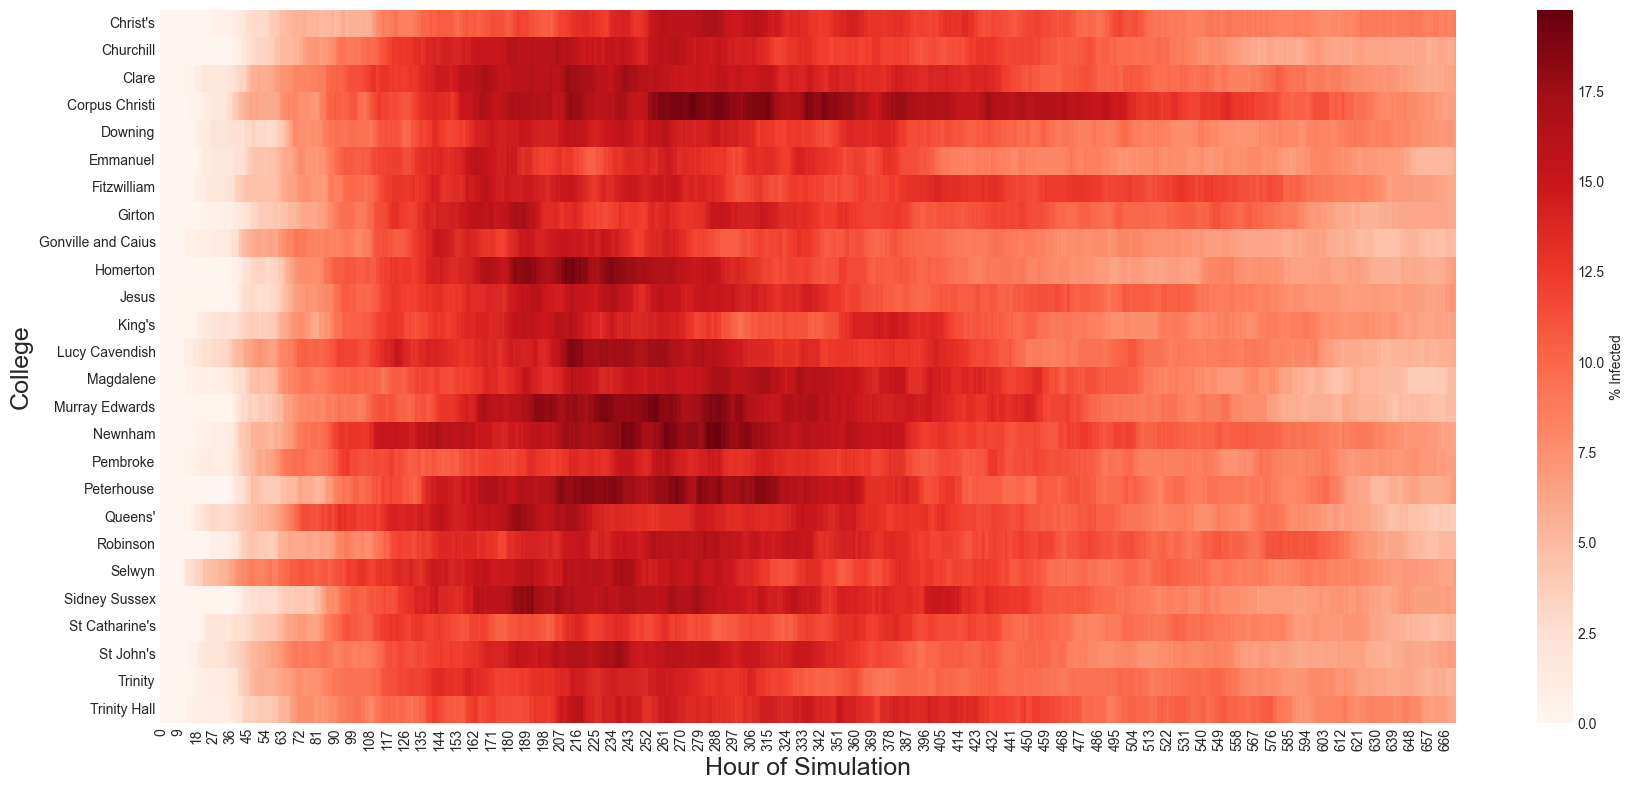

In [180]:
plt.figure(figsize=(18, 8))
sns.heatmap(college_infection_pct['A'].astype(float), cmap='Reds', cbar_kws={'label': '% Infected'})
#plt.title('Heatmap: % Infected per College Over Time (Disease A)')
plt.xlabel('Hour of Simulation', fontsize=18)
plt.ylabel('College', fontsize = 18)
plt.tight_layout()
plt.show()

In [181]:
# Identify the biggest 5 superspreaders for disease 'A', their attributes, total infections, and their top infection location

disease_letter = 'A'

# 1. Count infections caused by each student
spread_counts = infection_log[infection_log['disease'] == disease_letter]['source_student'].value_counts()
top_spreaders = spread_counts.head(5).index

# 2. Get their attributes from df
superspreader_info = df[df['StudentID'].isin(top_spreaders)][['StudentID', 'Subject', 'Year', 'College']].drop_duplicates()

# 3. For each superspreader, find the location where they infected the most people and their total infections
print("Top 5 superspreaders, their total infections, and main infection locations:")
for sid in top_spreaders:
    info = superspreader_info[superspreader_info['StudentID'] == sid].iloc[0]
    events = infection_log[(infection_log['disease'] == disease_letter) & (infection_log['source_student'] == sid)]
    total_infections = len(events)
    if not events.empty:
        top_location = events['location'].value_counts().idxmax()
        top_location_count = events['location'].value_counts().max()
    else:
        top_location = None
        top_location_count = 0
    print(f"StudentID: {info['StudentID']}, Subject: {info['Subject']}, Year: {info['Year']}, College: {info['College']}")
    print(f"  Total infections: {total_infections}")
    print(f"  Most infections at: {top_location} ({top_location_count} infections)")
    print("-" * 50)

Top 5 superspreaders, their total infections, and main infection locations:
StudentID: 5279, Subject: Hum, Soc & Pol Sciences Tripos, Year: 2, College: King's
  Total infections: 13
  Most infections at: King's College Canteen (6 infections)
--------------------------------------------------
StudentID: 5665, Subject: History & Politics Tripos, Year: 1, College: Lucy Cavendish
  Total infections: 13
  Most infections at: Lucy Cavendish Library (6 infections)
--------------------------------------------------
StudentID: 1736, Subject: Engineering Tripos, Year: 2, College: Downing
  Total infections: 13
  Most infections at: Downing Library (9 infections)
--------------------------------------------------
StudentID: 2178, Subject: Engineering Tripos, Year: 4, College: Emmanuel
  Total infections: 12
  Most infections at: Emmanuel Library (4 infections)
--------------------------------------------------
StudentID: 2474, Subject: Natural Sciences Tripos, Year: 2, College: Emmanuel
  Total i

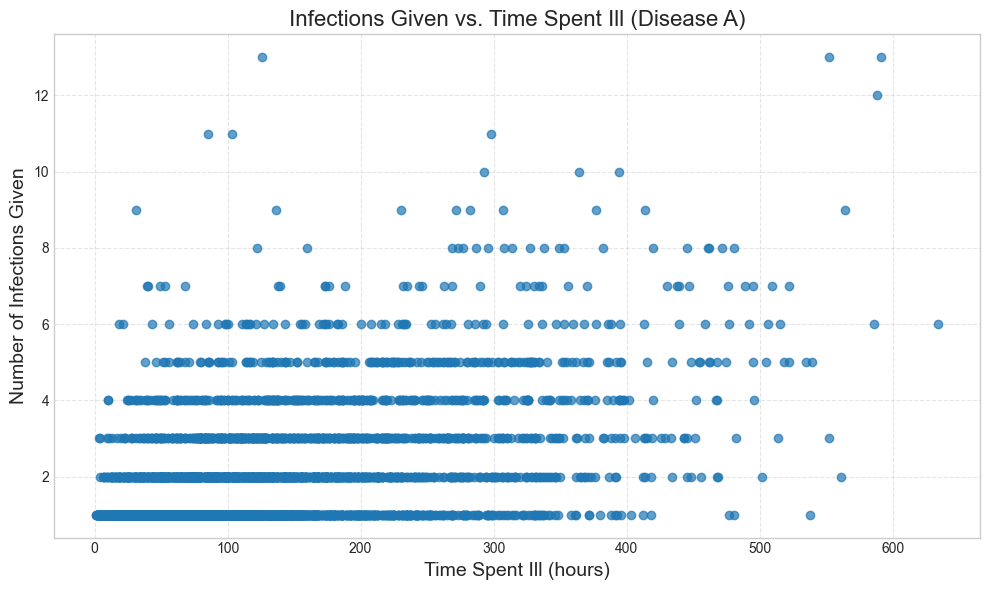

In [182]:
# Plot number of infections given per student against the time they were ill (for Disease 'A')

disease_letter = 'A'

# 1. Count number of infections given per student
infections_given = infection_log[infection_log['disease'] == disease_letter]['source_student'].value_counts()

# 2. Calculate time ill for each student (number of hours spent infected)
# Find all disease state columns for this disease
disease_cols = sorted([col for col in df.columns if col.startswith('Disease_T_')],
                      key=lambda x: int(re.search(r'(\d+)', x).group(1)))
disease_idx = disease_labels.index(disease_letter)

# For each student, count number of time points where state == '1' (infected)
ill_times = {}
for sid in df['StudentID'].unique():
    student_rows = df[df['StudentID'] == sid]
    if student_rows.empty:
        continue
    # Take the first row for this student (assuming static attributes)
    row = student_rows.iloc[0]
    infected_hours = 0
    for col in disease_cols:
        state = str(row[col]).zfill(len(disease_labels))
        if state[disease_idx] == '1':
            infected_hours += 1
    ill_times[sid] = infected_hours

# 3. Prepare data for plotting
x = []
y = []
for sid, n_infections in infections_given.items():
    if sid in ill_times:
        x.append(ill_times[sid])
        y.append(n_infections)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('Time Spent Ill (hours)', fontsize=14)
plt.ylabel('Number of Infections Given', fontsize=14)
plt.title('Infections Given vs. Time Spent Ill (Disease ' + disease_letter + ')', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [183]:
from scipy.stats import pearsonr

# x: time spent ill, y: infections given (from previous cell)
if len(x) > 1 and len(y) > 1:
    corr, pval = pearsonr(x, y)
    print(f"Pearson correlation: {corr:.3f} (p-value: {pval:.3g})")
    if pval < 0.05:
        print("There is a statistically significant correlation.")
    else:
        print("No statistically significant correlation found.")
else:
    print("Not enough data to compute correlation.")

Pearson correlation: 0.468 (p-value: 1.36e-232)
There is a statistically significant correlation.


C:\Users\joshu\AppData\Roaming\Python\Python313\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
C:\Users\joshu\AppData\Roaming\Python\Python313\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
C:\Users\joshu\AppData\Roaming\Python\Python313\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
C:\Users\joshu\AppData\Roaming\Python\Python313\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
C:\Users\joshu\AppData\Roaming\Python\Python313\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
C:\Users\joshu\AppData\Roaming\Python\Python313\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
C:\Users\joshu\AppData

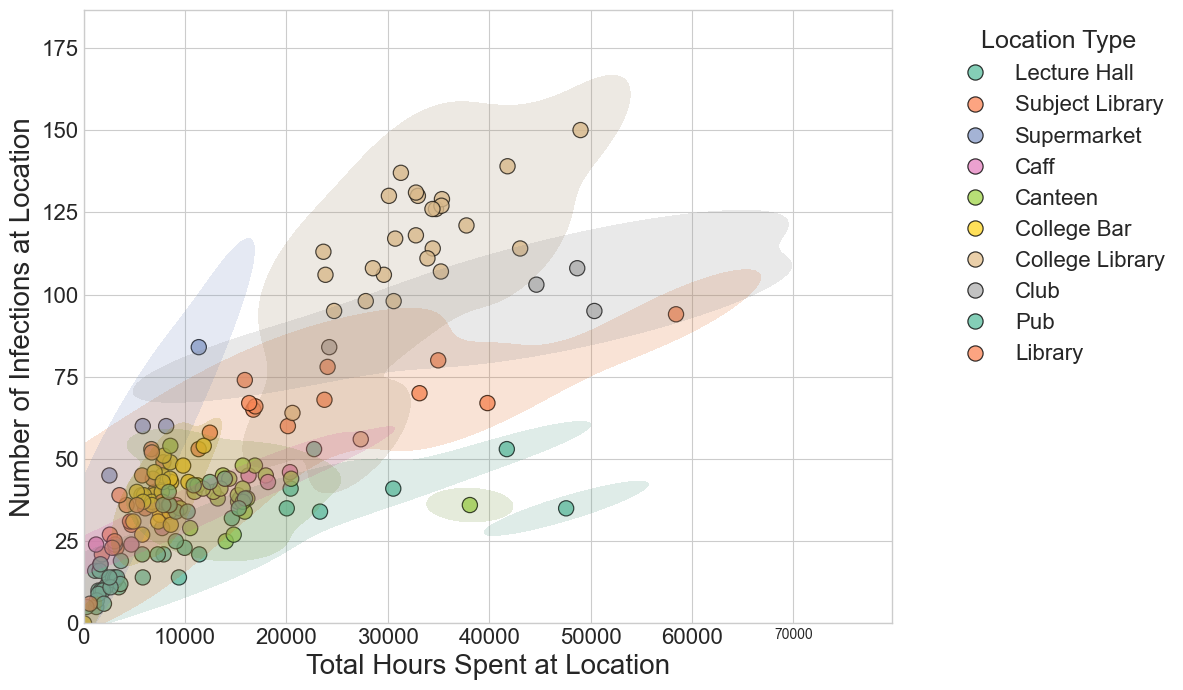

In [184]:
plt.figure(figsize=(12, 7))

# Plot scatter points as before
sns.scatterplot(
    data=loc_df,
    x='total_hours',
    y='infections',
    hue='type',
    palette='Set2',
    s=120,
    alpha=0.8,
    edgecolor='k'
)

# Overlay density contours ("zones") for each location type
for loc_type, color in zip(loc_df['type'].unique(), sns.color_palette('Set2')):
    subset = loc_df[loc_df['type'] == loc_type]
    if len(subset) > 2:  # Need at least 3 points for a contour
        sns.kdeplot(
            x=subset['total_hours'],
            y=subset['infections'],
            levels=2,
            color=color,
            fill=True,
            alpha=0.18,
            linewidths=0,
            label=None
        )

plt.xlabel('Total Hours Spent at Location', fontsize=20)
plt.ylabel('Number of Infections at Location', fontsize=20)
#plt.title('Infections vs. Hours at Location (Disease ' + disease_letter + ')', fontsize=24)
plt.legend(title='Location Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [185]:
infection_log = pd.read_csv('infection_events_log.csv')
disease_tracker = 'Disease_track_completeV3.csv'
df = pd.read_csv('Disease_track_completeV3.csv')

In [186]:
def analyze_and_plot_sir_combined(filepath):
    """
    Loads simulation data, analyzes infected and recovered counts for all diseases,
    and plots all diseases' infected numbers on one graph and all recovered numbers on another.
    Disease lines are labeled with their transmission and recovery rates.
    """
    # --- 1. Load Data ---
    print(f"Loading simulation results from '{filepath}'...")
    try:
        df = pd.read_csv(filepath)
        print("File loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        print("Please ensure the file is in the same directory as this notebook or provide the full path.")
        return

    # --- 2. Analyze Infected and Recovered Counts ---
    # Find all disease state columns and sort them chronologically
    disease_cols = sorted(
        [col for col in df.columns if col.startswith('Disease_T_')],
        key=lambda x: int(re.search(r'(\d+)', x).group(1))
    )
    
    if not disease_cols:
        print("Error: No 'Disease_T_...' columns found in the provided file.")
        return

    # Use the Disease objects defined earlier (not overwritten by any other cell)
    if isinstance(diseases[0], str):
        raise ValueError("The variable 'diseases' has been overwritten as a list of strings. "
                         "Please restart your kernel and ensure 'diseases' refers to your Disease objects.")

    disease_labels = [d.name for d in diseases]
    transmission_rates = {d.name: d.transmission_rate for d in diseases}
    recovery_rates = {d.name: d.recovery_rate for d in diseases}
    print(f"Found {len(disease_cols)} time steps to analyze...")

    results = {label: {'infected': [], 'recovered': []} for label in disease_labels}
    hours = []

    for col in disease_cols:
        t = int(re.search(r'(\d+)', col).group(1))
        hours.append(t)
        disease_states = df[col].astype(str).str.zfill(len(disease_labels))
        for i, label in enumerate(disease_labels):
            infected = (disease_states.str[i] == '1').sum()
            recovered = (disease_states.str[i] == '2').sum()
            results[label]['infected'].append(infected)
            results[label]['recovered'].append(recovered)

    # Plot infected numbers
    plt.figure(figsize=(14, 7))
    for label in disease_labels:
        plt.plot(hours, results[label]['infected'], 
                 label=f"{label} (β={transmission_rates[label]:.3f}, γ={recovery_rates[label]:.3f})")
    #plt.title('Number of Infected Students Over Time (All Diseases)')
    plt.xlabel('Hour of Simulation', fontsize = 20)
    plt.ylabel('Number of Infected Students', fontsize = 20)
    plt.legend(title='Disease (Transmission, Recovery Rate)', fontsize = 15)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot recovered numbers
    plt.figure(figsize=(14, 7))
    for label in disease_labels:
        plt.plot(hours, results[label]['recovered'], 
                 label=f"{label} (β={transmission_rates[label]:.3f}, γ={recovery_rates[label]:.3f})")
    #plt.title('Number of Recovered Students Over Time (All Diseases)')
    plt.xlabel('Hour of Simulation', fontsize = 20)
    plt.ylabel('Number of Recovered Students', fontsize = 20)
    plt.legend(title='Disease (Transmission, Recovery Rate)', fontsize = 15)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Loading simulation results from 'Disease_track_completeV3.csv'...
File loaded successfully.
Found 672 time steps to analyze...


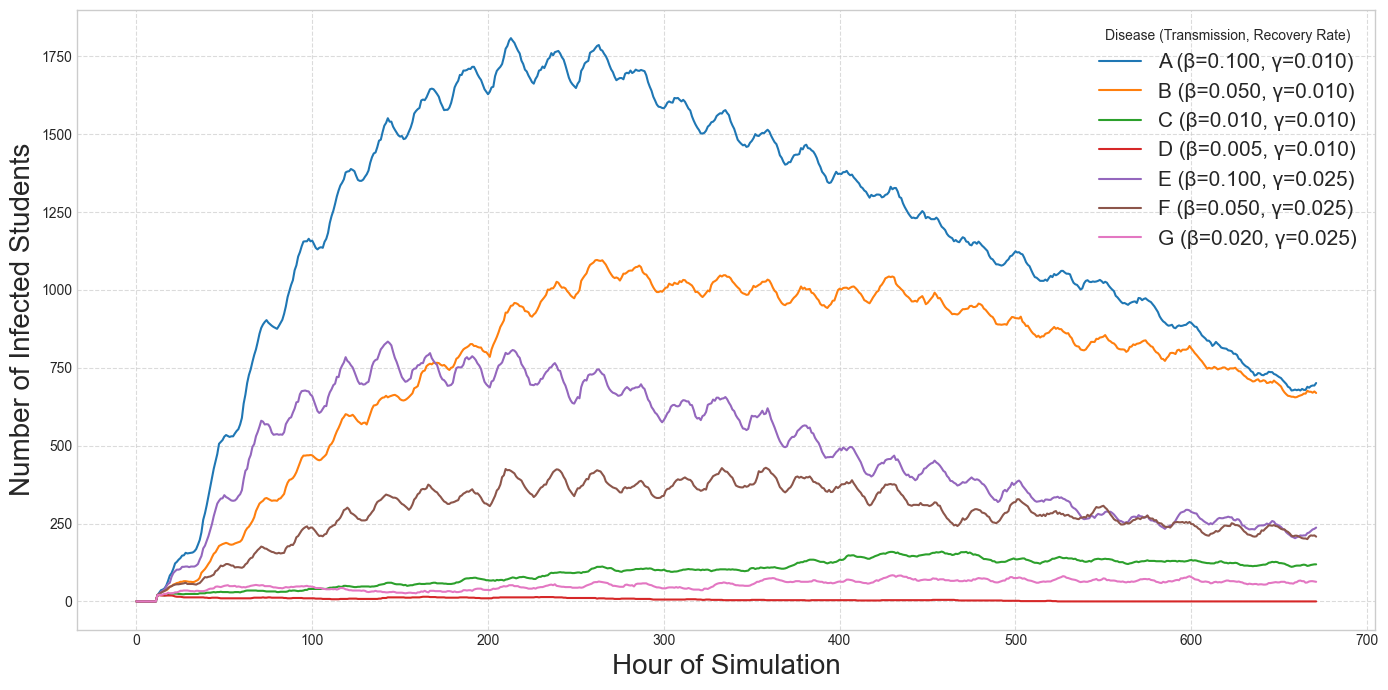

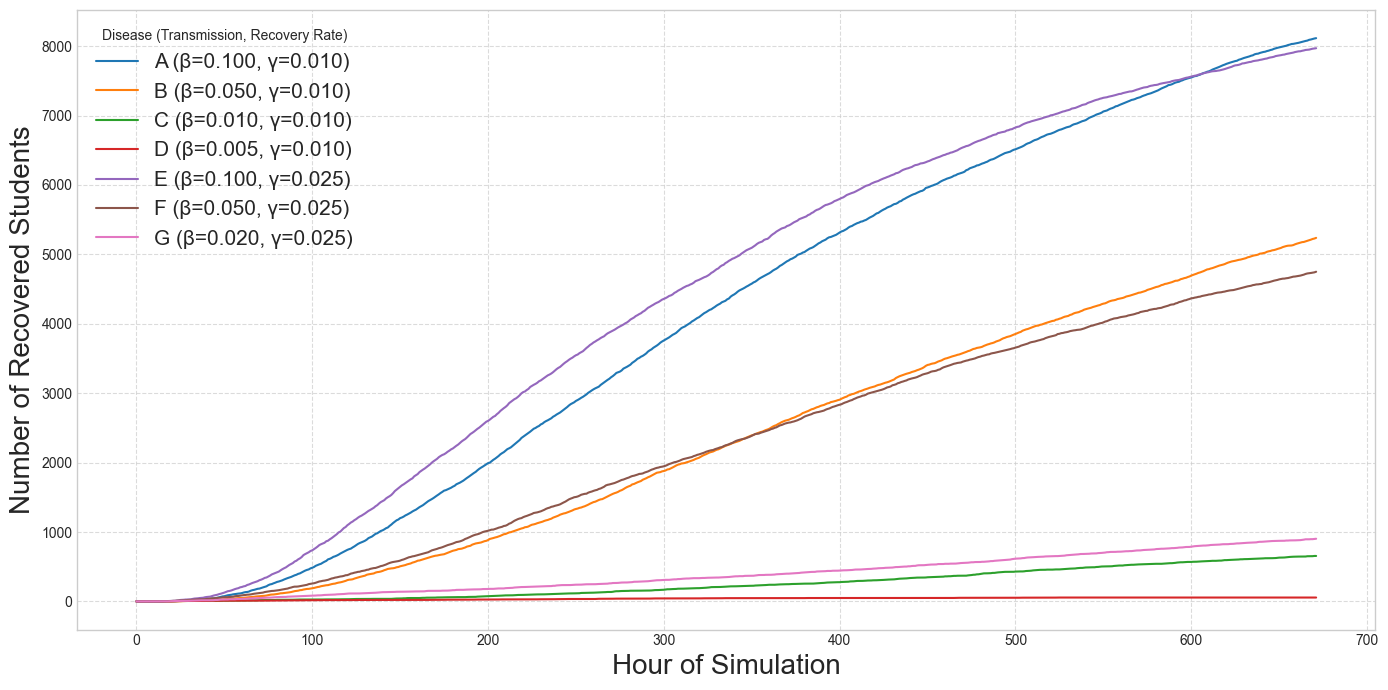

In [187]:
analyze_and_plot_sir_combined(disease_tracker)

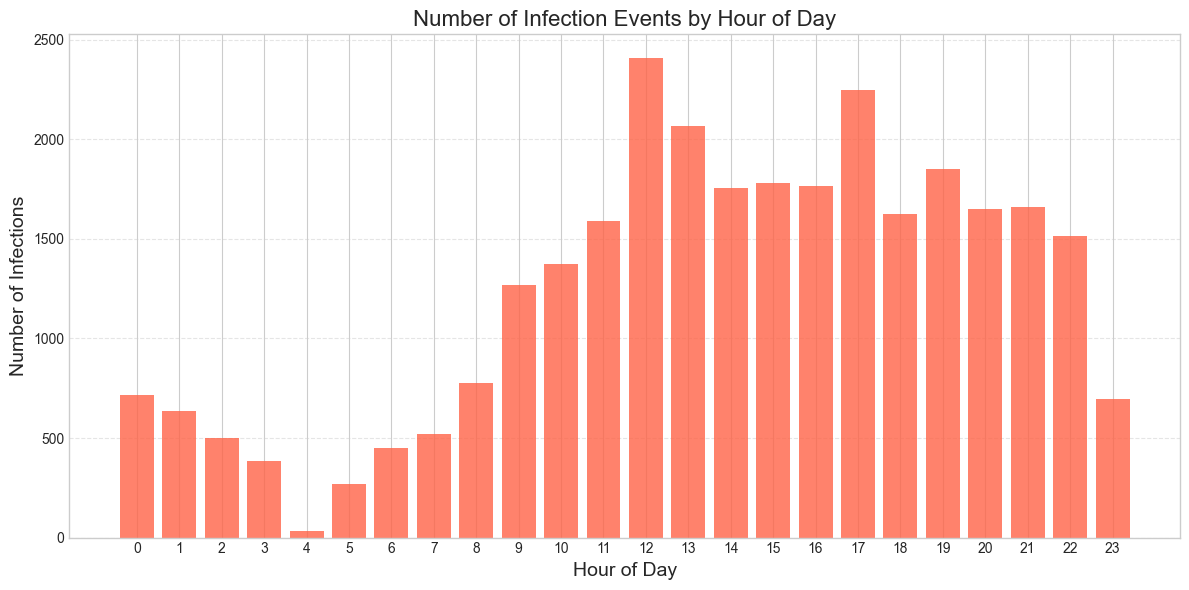

In [188]:
infection_log = pd.read_csv('infection_events_log.csv')
infection_log['HourOfDay'] = infection_log['time'] % 24
hour_counts = infection_log['HourOfDay'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(hour_counts.index, hour_counts.values, color='tomato', alpha=0.8)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Infections', fontsize=14)
plt.title('Number of Infection Events by Hour of Day', fontsize=16)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()